# FINAL ASSIGNMENT CAPSTONE PROJECT 
## Luis Viadero Barandica
### IBM Professional Certificate on Data Science

----

## INTRODUCTION TO THE CONTEXT OF THE ANALYSIS

### Importing Useful resources

In [6]:
#!pip install beautifulsoup4
#!pip install geopy

     |████████████████████████████████| 112kB 2.9MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
import requests
import urllib.request
import pandas as pd
import csv
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

## Get Madrid City Data

In [8]:
url2 = "https://en.wikipedia.org/wiki/Districts_of_Madrid"
response = requests.get(url2)

print(response.status_code)

200


In [11]:
soup2 = BeautifulSoup(response.content, 'html.parser')
table2 = soup2.findAll('table')[1]
values2 =[]
tr2 = table2.findAll(['tr'])

In [12]:
csvFile = open("Madrid_Boroughs.csv",'wt',newline='',encoding='utf-8')
writer = csv.writer(csvFile)  
try:   
        for cell in tr2:
            th2 = cell.find_all('th')
            th_data2 = [col.text.strip('\n') for col in th2]
            td2 = cell.find_all('td')
            row2 = [i.text.replace('\n',' ') for i in td2]
            writer.writerow(th_data2+row2)      
        
finally:   
    csvFile.close()

In [13]:
madrid_df = pd.read_csv('Madrid_Boroughs.csv', sep=',')
madrid_df = madrid_df[['District Number','Name','Population','Administrative wards']]
madrid_df['Administrative wards'] = madrid_df['Administrative wards'].str.replace('\d+','')
madrid_df['Administrative wards'] = madrid_df['Administrative wards'].str.replace('(','| ')
madrid_df['Administrative wards'] = madrid_df['Administrative wards'].str.replace(')','')
madrid_df.dropna(subset=['District Number'],inplace=True)
madrid_df['District Number'] = madrid_df['District Number'].astype(int)
madrid_df.tail(5)

,District Number,Name,Population,Administrative wards
16,17,Villaverde,"142,608",Villaverde Alto | San Cristóbal | Butarque | L...
17,18,Villa de Vallecas,"104,421",Casco Histórico de Vallecas | Santa Eugenia | ...
18,19,Vicálvaro,"70,051",Casco Histórico de Vicálvaro | Valdebernardo |...
19,20,San Blas-Canillejas,"154,357",Simancas | Hellín | Amposta | Arcos | Rosas | ...
20,21,Barajas,"46,876",Alameda de Osuna | Aeropuerto | Casco Históric...


In [14]:
# number of empty cell in Neighborhood column
na_neighborhood = madrid_df[madrid_df['Name'].isna()].shape[0]
print(na_neighborhood)

0


In [15]:
geolocator = Nominatim(user_agent="ny_explorer")
address ='Madrid Centro, MAD'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Madrid City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Madrid City are 40.4263123, -3.6956708.


In [16]:
for district in madrid_df['Name']:
    address = district + ', Madrid'
    
    location = geolocator.geocode(address)
    madrid_df.loc[madrid_df['Name']==district,'latitude'] = location.latitude
    madrid_df.loc[madrid_df['Name']==district,'longitude'] = location.longitude

In [17]:
madrid_df.head()

,District Number,Name,Population,Administrative wards,latitude,longitude
0,1,Centro,"131,928",Palacio | Embajadores | Cortes | Justicia | Un...,40.417653,-3.707914
1,2,Arganzuela,"151,965",Imperial | Acacias | Chopera | Legazpi | Delic...,40.396954,-3.697289
2,3,Retiro,"118,516",Pacífico | Adelfas | Estrella | Ibiza | Jerón...,40.411150,-3.676057
3,4,Salamanca,"143,800",Recoletos | Goya | Fuente del Berro | Guindale...,40.427045,-3.680602
4,5,Chamartín,"143,424",El Viso | Prosperidad | Ciudad Jardín | Hispan...,40.458987,-3.676129


### Let's visualize the map pf Madrid with its different districts:

In [18]:
districts_list = madrid_df.Name.unique()
districts_color = {}
for district in districts_list:
    districts_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(250), size=3))

In [24]:
# create map of New York using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(madrid_df['latitude'], madrid_df['longitude'], madrid_df['Name']):
    label = '{}'.format(district)#,madrid_df.loc[district]['Population'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=districts_color[district],
        fill=True,
        fill_color=districts_color[district],
        fill_opacity=0.8,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

### FourSquar information

In [25]:
CLIENT_ID = 'YIWBHL3UNKDRFCVLK3IFQHMAW4U2GFPEYX4SPSUEWFFF20HH' # your Foursquare ID
CLIENT_SECRET = 'L0D3JHI0MD5XTHHJXC2CMY5HLTQKQKDKODDEODSYL445WNYZ' # your Foursquare Secret
ACCESS_TOKEN = 'FW52M5BMFG4MAFQPVFJP5OIC1M534TLHOGYF04PTQAYR5PGO'
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YIWBHL3UNKDRFCVLK3IFQHMAW4U2GFPEYX4SPSUEWFFF20HH
CLIENT_SECRET:L0D3JHI0MD5XTHHJXC2CMY5HLTQKQKDKODDEODSYL445WNYZ


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
madrid_venues = getNearbyVenues(names=madrid_df['Name'],
                                latitudes=madrid_df['latitude'],
                                longitudes=madrid_df['longitude'])
madrid_venues[:5]

Centro 
Arganzuela 
Retiro 
Salamanca 
Chamartín 
Tetuán 
Chamberí 
Fuencarral-El Pardo 
Moncloa-Aravaca 
Latina 
Carabanchel 
Usera 
Puente de Vallecas 
Moratalaz 
Ciudad Lineal 
Hortaleza 
Villaverde 
Villa de Vallecas 
Vicálvaro 
San Blas-Canillejas 
Barajas 


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.417653,-3.707914,Plaza de Isabel II,40.418114,-3.709397,Plaza
1,Centro,40.417653,-3.707914,Cerveceria Erte,40.419241,-3.707470,Bar
2,Centro,40.417653,-3.707914,Amorino,40.416065,-3.708383,Ice Cream Shop
3,Centro,40.417653,-3.707914,TOC Hostel,40.417264,-3.705928,Hostel
4,Centro,40.417653,-3.707914,Torrons Vicens: Artesa D' Agramunt,40.416095,-3.708119,Pastry Shop
5,Centro,40.417653,-3.707914,Trattoria Malatesta,40.416788,-3.707182,Italian Restaurant
6,Centro,40.417653,-3.707914,Casa Jaguar,40.419019,-3.708516,Bistro
7,Centro,40.417653,-3.707914,La Esquina del Real,40.417356,-3.710364,French Restaurant
8,Centro,40.417653,-3.707914,Plaza Mayor,40.415527,-3.707506,Plaza
9,Centro,40.417653,-3.707914,Gyoza Go!,40.416179,-3.708612,Dumpling Restaurant


In [41]:
madrid_venues['Venue Category'].replace(['Sushi Restaurant', 'Japanese Restaurant','Asian Restaurant'],'Japanese Restaurant',inplace=True)
madrid_venues['Venue Category'].replace(['Chinese Restaurant','Noodle House', 'Cantonese Restaurant'],'Chinese Restaurant',inplace=True)

madrid_venues.groupby('Neighborhood')['Venue'].count().sort_values(ascending=False)

Neighborhood
Salamanca               92
Chamberí                81
Centro                  80
Barajas                 43
Chamartín               42
Tetuán                  38
Arganzuela              37
Ciudad Lineal           30
Retiro                  24
Hortaleza               18
Usera                   18
Moratalaz               17
Carabanchel             13
Villa de Vallecas       11
San Blas-Canillejas     10
Latina                   8
Puente de Vallecas       8
Villaverde               3
Moncloa-Aravaca          3
Vicálvaro                1
Name: Venue, dtype: int64

In [32]:
# Check if Japanese restaurant are in there
"Japanese Restaurant" in madrid_venues['Venue Category'].unique()

True

In [42]:
to_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

to_onehot['Neighborhoods'] = madrid_venues['Neighborhood'] 


fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(577, 127)


,Neighborhoods,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Candy Store,Castle,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Department Store,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Opera House,Other Nightlife,Park,Pastry Shop,Perfume Shop,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Rental Service,Resort,Restaurant,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Student Center,Supermarket,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Wine Bar,Women's Store
0,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
madrid_df.sample(1)

,District Number,Name,Population,Administrative wards,latitude,longitude
1,2,Arganzuela,"151,965",Imperial | Acacias | Chopera | Legazpi | Delic...,40.396954,-3.697289


In [60]:
madrid_to_grouped = to_onehot.groupby(["Neighborhoods"]).agg(
    Japanese_Restaurant_MEAN=('Japanese Restaurant','mean'), Japanese_Restaurant_Dev=('Japanese Restaurant','std'),
    Chinese_Restaurant_MEAN=('Chinese Restaurant','mean'), Chinese_Restaurant_Dev=('Chinese Restaurant','std')
    
).reset_index()

madrid_to_grouped_pop = madrid_to_grouped.merge(madrid_df[['Name','Population']], how='left',left_on='Neighborhoods',right_on='Name')

print(madrid_to_grouped_pop.shape)
EDA= madrid_to_grouped_pop[['Neighborhoods','Japanese_Restaurant_MEAN','Japanese_Restaurant_Dev','Population']].sort_values('Japanese_Restaurant_MEAN',ascending=False)[:9]
EDA

(20, 7)


,Neighborhoods,Japanese_Restaurant_MEAN,Japanese_Restaurant_Dev,Population
11,Puente de Vallecas,0.125000,0.353553,"227,595"
18,Villa de Vallecas,0.090909,0.301511,"104,421"
15,Tetuán,0.078947,0.273276,"153,789"
16,Usera,0.055556,0.235702,"134,791"
1,Barajas,0.046512,0.213083,"46,876"
5,Chamberí,0.037037,0.190029,"137,401"
4,Chamartín,0.023810,0.154303,"143,424"
13,Salamanca,0.021739,0.146630,"143,800"
3,Centro,0.012500,0.111803,"131,928"


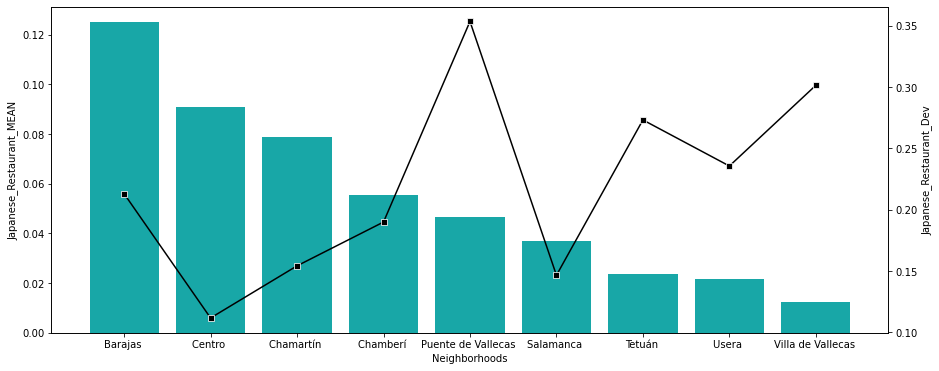

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
sns.barplot(x=EDA['Neighborhoods'],y=EDA['Japanese_Restaurant_MEAN'],data=EDA,color='c',ax=ax1)
sns.lineplot(x=EDA['Neighborhoods'],y=EDA['Japanese_Restaurant_Dev'],data=EDA,marker='s',color='k',ax=ax2)
plt.xticks(rotation=60)
plt.show()
plt.close()

In [84]:
madrid_to_grouped_pop[madrid_to_grouped_pop["Japanese_Restaurant_MEAN"] > 0]

,Neighborhoods,Japanese_Restaurant_MEAN,Japanese_Restaurant_Dev,Chinese_Restaurant_MEAN,Chinese_Restaurant_Dev,Name,Population
1,Barajas,0.046512,0.213083,0.000000,0.000000,Barajas,"46,876"
3,Centro,0.012500,0.111803,0.012500,0.111803,Centro,"131,928"
4,Chamartín,0.023810,0.154303,0.000000,0.000000,Chamartín,"143,424"
5,Chamberí,0.037037,0.190029,0.000000,0.000000,Chamberí,"137,401"
11,Puente de Vallecas,0.125000,0.353553,0.000000,0.000000,Puente de Vallecas,"227,595"
13,Salamanca,0.021739,0.146630,0.000000,0.000000,Salamanca,"143,800"
15,Tetuán,0.078947,0.273276,0.052632,0.226294,Tetuán,"153,789"
16,Usera,0.055556,0.235702,0.111111,0.323381,Usera,"134,791"
18,Villa de Vallecas,0.090909,0.301511,0.000000,0.000000,Villa de Vallecas,"104,421"


In [102]:
Japaneser = madrid_to_grouped_pop[["Neighborhoods","Japanese_Restaurant_MEAN",'Japanese_Restaurant_Dev','Population','Chinese_Restaurant_MEAN']]

data = Japaneser.Population.tolist()

splited_list = [i.split(',') for i in data]
converted_list = [int(''.join(i)) for i in splited_list]

Japaneser["Population"] = converted_list
Japaneser.replace(np.nan,0,inplace=True)
Japaneser.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Neighborhoods,Japanese_Restaurant_MEAN,Japanese_Restaurant_Dev,Population,Chinese_Restaurant_MEAN
0,Arganzuela,0.000000,0.000000,151965,0.027027
1,Barajas,0.046512,0.213083,46876,0.000000
2,Carabanchel,0.000000,0.000000,243998,0.000000
3,Centro,0.012500,0.111803,131928,0.012500
4,Chamartín,0.023810,0.154303,143424,0.000000


In [103]:
# We decided to use k-means clustering 
from sklearn.cluster import KMeans
toclusters = 3

to_clustering = Japaneser.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=1)
kmeans.fit_transform(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0],
      dtype=int32)

In [104]:
madrid_to_merged = Japaneser.copy()

madrid_to_merged["Cluster Labels"] = kmeans.labels_
madrid_to_merged

,Neighborhoods,Japanese_Restaurant_MEAN,Japanese_Restaurant_Dev,Population,Chinese_Restaurant_MEAN,Cluster Labels
0,Arganzuela,0.000000,0.000000,151965,0.027027,0
1,Barajas,0.046512,0.213083,46876,0.000000,2
2,Carabanchel,0.000000,0.000000,243998,0.000000,1
3,Centro,0.012500,0.111803,131928,0.012500,0
4,Chamartín,0.023810,0.154303,143424,0.000000,0
5,Chamberí,0.037037,0.190029,137401,0.000000,0
6,Ciudad Lineal,0.000000,0.000000,212529,0.033333,1
7,Hortaleza,0.000000,0.000000,180462,0.000000,0
8,Latina,0.000000,0.000000,233808,0.000000,1
9,Moncloa-Aravaca,0.000000,0.000000,116903,0.000000,0


In [105]:
madrid_to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)

madrid_to_merged = madrid_to_merged.join(madrid_venues.set_index("Neighborhood"), on="Neighborhood")
madrid_to_merged.sort_values(["Cluster Labels"], inplace=True)
print(madrid_to_merged.shape)
madrid_to_merged.head()

(577, 12)


,Neighborhood,Japanese_Restaurant_MEAN,Japanese_Restaurant_Dev,Population,Chinese_Restaurant_MEAN,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arganzuela,0.000000,0.00000,151965,0.027027,0,40.396954,-3.697289,Go Hyang Mat,40.396512,-3.699201,Korean Restaurant
13,Salamanca,0.021739,0.14663,143800,0.000000,0,40.427045,-3.680602,TreZe Restaurante & Bar,40.427188,-3.678429,Mediterranean Restaurant
13,Salamanca,0.021739,0.14663,143800,0.000000,0,40.427045,-3.680602,Rawcoco Green Bar,40.426132,-3.678594,Juice Bar
12,Retiro,0.000000,0.00000,118516,0.000000,0,40.411150,-3.676057,Parque Colonia del Retiro,40.409351,-3.671431,Playground
12,Retiro,0.000000,0.00000,118516,0.000000,0,40.411150,-3.676057,Bar La Colonia,40.409056,-3.672145,Spanish Restaurant


In [123]:
map_clusters = folium.Map(location=[latitude, longitude],zoom_start=11)

# Create color sceme
# add markers to the map
markers_colors={}
markers_colors[0] = 'blue'
markers_colors[1] = 'red'
markers_colors[2] = 'black'

for lat, lon, cluster in zip(madrid_to_merged['Neighborhood Latitude'], 
                             madrid_to_merged['Neighborhood Longitude'], 
                             madrid_to_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Conclusion

In [122]:
madrid_to_merged.groupby('Cluster Labels').agg(
    Japanese_Restaurant_MEAN=('Japanese_Restaurant_MEAN','mean'),Japanese_Restaurant_Dev=('Japanese_Restaurant_Dev','std'),
    Population_MEAN =('Population','mean'),
    Chinese_Restaurant_MEAN=('Chinese_Restaurant_MEAN','mean'),
    Venues = ('Venue Latitude','count')
).T.round(3)

Cluster Labels,0,1,2
Japanese_Restaurant_MEAN,0.025,0.017,0.042
Japanese_Restaurant_Dev,0.081,0.122,0.105
Population_MEAN,141804.612,224390.983,67162.486
Chinese_Restaurant_MEAN,0.013,0.017,0.000
Venues,446.000,59.000,72.000


It seems that **clusert 0** has a suitable venues profile to open our new Japanese restaurant. We can tell this by interpreting the resutls from the clusters and the aggregated values of the characteristics we chose to build these clusters. Thus, Cluser 0 has an acceptable presence of Japanse gastronomy, but not only that, it also has presence of other gastronomies sich Chinese restaurant, what may suggest that these districts have demand for this food experiences. Moreover, it also covers a huge population and wide area where to position our restaurant (a total of 446). venues

In [126]:
#Cluster 0
madrid_to_merged.loc[(madrid_to_merged['Cluster Labels'] ==0),:].groupby('Neighborhood').agg(
    Japanese_MEAN=('Japanese_Restaurant_MEAN','max'), Population=('Population','max'), Venues_TOTAL =('Venue','count'), Venue_Diversity=('Venue','nunique'),
    Chinese_MEAN=('Chinese_Restaurant_MEAN','mean')
    
).sort_values('Japanese_MEAN',ascending=False)

,Japanese_MEAN,Population,Venues_TOTAL,Venue_Diversity,Chinese_MEAN
Neighborhood,,,,,
Tetuán,0.078947,153789,38,38,0.052632
Usera,0.055556,134791,18,18,0.111111
Chamberí,0.037037,137401,81,81,0.000000
Chamartín,0.023810,143424,42,42,0.000000
Salamanca,0.021739,143800,92,91,0.000000
Centro,0.012500,131928,80,78,0.012500
Arganzuela,0.000000,151965,37,37,0.027027
Hortaleza,0.000000,180462,18,18,0.000000
Moncloa-Aravaca,0.000000,116903,3,3,0.000000
